In [1]:
import torch
print(torch.version.cuda)
print(torch.cuda.is_available())


11.7
True


In [ ]:
# Create a MPS device
# device = torch.device("mps")
# device

In [2]:
use_cuda=torch.cuda.is_available()
device=torch.device('cuda:0' if use_cuda else 'cpu')

In [ ]:
! pip install SentencePiece


In [ ]:
! pip install langid

In [ ]:
! pip install unidecode

In [ ]:
! pip install transformers


In [ ]:
! pip install pandas

In [ ]:
! pip install -U matplotlib

In [ ]:
! pip install wandb

In [3]:
! wandb login 0cf8d63ac20cff538d748e7412a8d60561ff1268

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\priya/.netrc


In [ ]:
! pip install -U scikit-learn

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader,random_split,RandomSampler, SequentialSampler
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup,GPT2Config
import pandas as pd
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
from IPython import display
plt.rcParams["figure.figsize"] = 8, 6
# import wandb
import re
from collections import Counter

import unidecode
import langid
import random
from sklearn.model_selection import ParameterGrid
import torch.optim as optim


In [4]:
full_dataset =pd.read_csv('../dataset/all_quotes.csv',low_memory=False)
full_dataset=full_dataset.head(100) #For testing purpose only
print(full_dataset.shape)


(100, 5)


In [5]:
full_dataset.head()

,Unnamed: 0,quotes,author,tag,other_tags
0,0,“Control of consciousness determines the quali...,"― Mihaly Csikszentmihalyi, Flow: The Psycholog...",happiness,"[' consciousness, happiness, quality-of-life']"
1,1,“Copulation is no more foul to me than death is.”,"― Walt Whitman, Leaves of Grass: The First (18...",death,"[' death, sex']"
2,2,“Hope is a dream of which we long to have. Don...,"― Peace Gypsy, Souls Deep",happiness,"[' dreamers, dreams, happiness, love, peace']"
3,3,“True devotion and humility is when you carele...,― Michael Bassey Johnson,truth,"[' acceptance, achilles-heel, admiration, affe..."
4,4,"“Truths are written, never said... Lines are d...","― Colleen Hoover, Maybe Someday",poetry,"[' love, maybe-someday, poetry, ridge-lawson']"


In [6]:
new_dataset = full_dataset[['quotes', 'tag']]
new_dataset = new_dataset[new_dataset['quotes'].apply(lambda x: unidecode.unidecode(x).isascii())]

# Set the seed for reproducibility
random.seed(123)

# Define a function to detect the language of a string
def detect_language(text):
    return langid.classify(text)[0]

# Add a new column to the DataFrame with the language of each quote
new_dataset['language'] = new_dataset['quotes'].apply(detect_language)

# Filter the DataFrame to keep only the rows where the language is English
new_dataset = new_dataset[new_dataset['language'] == 'en']

# Drop the language column from the DataFrame
new_dataset = new_dataset.drop('language', axis=1)
new_dataset = new_dataset.reset_index(drop=True)
print(new_dataset.shape)

(95, 2)


           tag  count
3       poetry     15
1        death     13
0    happiness     12
8      success     10
2        truth      9
5      romance      9
6         love      9
4  inspiration      6
7      science      6
9         time      6


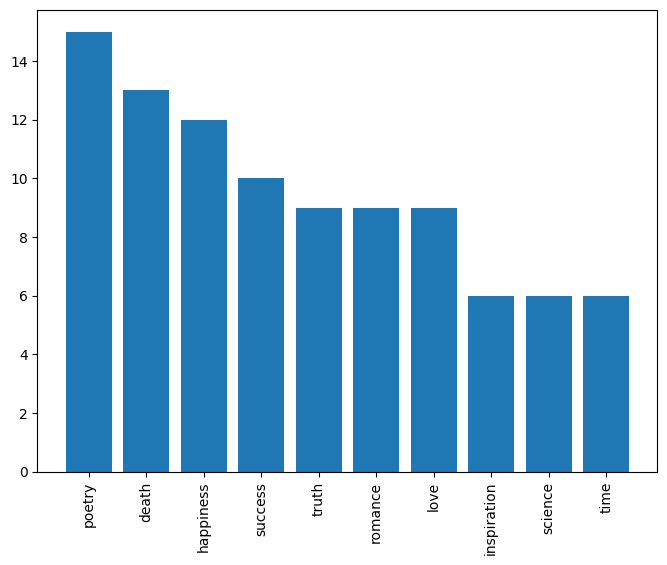

In [7]:
# Lowercase the text
# full_dataset['tags'] = full_dataset['tags'].apply(lambda x: x.lower())
tag_string = ','.join(new_dataset['tag'])
tag_list = [tag.strip() for tag in tag_string.split(',')] # all tags in this list
tag_counts = Counter(tag_list)
tag_df = pd.DataFrame({'tag': tag_counts.keys(), 'count': tag_counts.values()})
tag_df = tag_df.sort_values(by='count', ascending=False)
print(tag_df)
plt.bar(tag_df['tag'][:50], tag_df['count'][:50])
plt.xticks(rotation=90)
plt.show()

In [8]:
new_dataset['quotes'] = new_dataset['quotes'].str.replace('“', '')
new_dataset['quotes'] = new_dataset['quotes'].str.replace('”', '')

In [9]:
#Data preprocessing
# Remove new line
new_dataset['quotes'] = new_dataset['quotes'].apply(lambda x: re.sub(r'\n+', ' ', x))

# Lowercase the text
new_dataset['quotes'] = new_dataset['quotes'].apply(lambda x: x.lower())

In [10]:
def plot_word_distribution(sentences):
    # Initialize a dictionary to keep track of the count of sentences in each bin
    bin_counts = {'0-100': 0, '100-200': 0, '200-300': 0, '300-400': 0, '400-500': 0, '500-600': 0, '600+': 0}
    sentence_lengths = []
    
    for sentence in sentences:
        # Get the length of the sentence in words
        length = len(sentence.split())
        sentence_lengths.append(length)
        
        # Update the count of sentences in the appropriate bin
        if length <= 100:
            bin_counts['0-100'] += 1
        elif length <= 200:
            bin_counts['100-200'] += 1
        elif length <= 300:
            bin_counts['200-300'] += 1
        elif length <= 400:
            bin_counts['300-400'] += 1
        elif length <= 500:
            bin_counts['400-500'] += 1
        elif length <= 600:
            bin_counts['500-600'] += 1
        else:
            bin_counts['600+'] += 1   
    # Print the counts of sentences in each bin
    print(f"Sentences with 0-100 words: {bin_counts['0-100']}")
    print(f"Sentences with 100-200 words: {bin_counts['100-200']}")
    print(f"Sentences with 200-300 words: {bin_counts['200-300']}")
    print(f"Sentences with 300-400 words: {bin_counts['300-400']}")
    print(f"Sentences with 400-500 words: {bin_counts['400-500']}")
    print(f"Sentences with 500-600 words: {bin_counts['500-600']}")
    print(f"Sentences with 600+ words: {bin_counts['600+']}")

plot_word_distribution(new_dataset['quotes'])


Sentences with 0-100 words: 94
Sentences with 100-200 words: 1
Sentences with 200-300 words: 0
Sentences with 300-400 words: 0
Sentences with 400-500 words: 0
Sentences with 500-600 words: 0
Sentences with 600+ words: 0


In [11]:
def max_words_sentence(sentences):
    sentence_lengths = [len(s.split()) for s in sentences]
    max_length = max(sentence_lengths)
    max_sentence = sentences[sentence_lengths.index(max_length)]
    return max_sentence, max_length
max_words_sentence(new_dataset['quotes'])

('camels can go many weeks without drinking anything at all. the notion that they cache water in their humps is pure myth—their humps are made of fat, and water is stored in their body tissues. while other mammals draw water from bloodstreams when faced with dehydration, leading to death by volume shock, camels tap the water in their tissues, keeping their blood volume stable. though this reduces the camel’s bulk, they can lose up to a third of their body weight with no ill effects, which they can replace astonishingly quickly, as they are able to drink up to forty gallons in a single watering. (pp.69-70)',
 106)

In [12]:
max_length_value=768

In [13]:
class QuotesDataset(Dataset):
    def __init__(self, quotes, tokenizer,max_length_value):
        self.input_ids = []
        self.attn_masks = []
        self.tokenizer = tokenizer

        for quote in quotes:
          encodings_dict = tokenizer("<|startoftext|>"+quote+"<|endoftext|>",
                                    truncation=True,
                                    max_length=max_length_value,
                                    padding="max_length") #We are using max length padding
          
          self.input_ids.append(torch.tensor(encodings_dict["input_ids"]))
          self.attn_masks.append(torch.tensor(encodings_dict["attention_mask"]))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx]

In [14]:
#Hyper parameters

all_hyper_parameters= {
    "batch_size":[4,5],
    "lr":[2e-5,5e-5],
    "optimizer":['AdamW','Adagrad'],
    "warmup_steps":[100,500],
    "num_epochs": [4, 5],
    }

In [15]:
quotes = new_dataset['quotes']
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', 
                                          bos_token='<|startoftext|>', 
                                          eos_token='<|endoftext|>', 
                                          pad_token='<|pad|>')

final_dataset = QuotesDataset(quotes, tokenizer,max_length_value)
train_size = int(0.8*len(final_dataset))
val_size = len(final_dataset) - train_size
print(train_size,val_size)
train_dataset, val_dataset = random_split(final_dataset, [train_size, val_size])

# Load model configuration
config = GPT2Config.from_pretrained("gpt2")

# Create model instance and set embedding length
model = GPT2LMHeadModel.from_pretrained("gpt2", config=config)
model.resize_token_embeddings(len(tokenizer))

# Running the model on GPU
model = model.to(device)

grid=ParameterGrid(all_hyper_parameters)
loss_values=[]
combination=0
for hyper_param in grid: 
    combination=combination+1
    print(f'combination {combination} ,num_epochs: {hyper_param["num_epochs"]} ,batch_size: {hyper_param["batch_size"]} ,learning_rate: {hyper_param["lr"]} ,optimizer: {hyper_param["optimizer"]} ,warm_up_step: {hyper_param["warmup_steps"]}')
    train_dataloader = DataLoader(train_dataset,
                                sampler=RandomSampler(train_dataset),
                                batch_size=hyper_param['batch_size'])

    val_dataloader = DataLoader(val_dataset,
                                sampler=SequentialSampler(val_dataset),
                                batch_size=hyper_param['batch_size'])

    if hyper_param['optimizer']=='AdamW':
        optimizer = AdamW(model.parameters(), lr=hyper_param['lr'], eps=1e-8)
    else:
        optimizer = optim.Adagrad(model.parameters(), lr=hyper_param['lr'])


    # Toatl training steps is the number of data points times the number of epochs
    total_training_steps = len(train_dataloader)*hyper_param['num_epochs']

    # Setting a variable learning rate using scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=hyper_param['warmup_steps'],
                                                num_training_steps=total_training_steps)
    training_stats = []
    all_training_loss=[]
    all_valid_loss=[]
    for epoch_i in range(hyper_param['num_epochs']):
        print(f"Beginning epoch {epoch_i+1} of {hyper_param['num_epochs']}")
        total_train_loss = 0
        model.train()

        # Labels are shifted by 1 timestep
        for step, batch in enumerate(train_dataloader):
            b_input_ids = batch[0].to(device)
            b_labels = batch[0].to(device)
            b_masks = batch[1].to(device)

            model.zero_grad()

            outputs = model(b_input_ids,
                            labels=b_labels,
                            attention_mask=b_masks)
            
            loss = outputs[0]

            batch_loss = loss.item()
            total_train_loss += batch_loss
            loss.backward()
            optimizer.step()
            scheduler.step()

        all_training_loss.append(total_train_loss)
        avg_train_loss = total_train_loss / len(train_dataloader)
        print(f'Average Training Loss: {avg_train_loss}.')
        
        model.eval()

        total_eval_loss = 0
        nb_eval_steps = 0

        for batch in val_dataloader:
            b_input_ids = batch[0].to(device)
            b_labels = batch[0].to(device)
            b_masks = batch[1].to(device)
                
            with torch.no_grad():        

                outputs  = model(b_input_ids,  
                                attention_mask = b_masks,
                                labels=b_labels)
                
                loss = outputs[0]  
                    
            batch_loss = loss.item()
            total_eval_loss += batch_loss   

        all_valid_loss.append(total_eval_loss)
        avg_val_loss = total_eval_loss / len(val_dataloader) 
        print(f'Validation loss: {avg_val_loss}.')
        hyper_dict = {
        "hyperparameters": f'num_epochs: {hyper_param["num_epochs"]} batch_size: {hyper_param["batch_size"]} learning_rate: {hyper_param["lr"]} optimizer: {hyper_param["optimizer"]} warm_up_step: {hyper_param["warmup_steps"]}',
        "train_loss": all_training_loss,
        "val_loss": all_valid_loss}
        loss_values.append(hyper_dict)
  

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


76 19
num_epochs: 4 batch_size: 4 learning_rate: 2e-05 optimizer: AdamW warm_up_step: 100
Beginning epoch 1 of 4


c:\Users\priya\anaconda3\envs\my_env_2\lib\site-packages\transformers\optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Average Training Loss: 4.474377883108039.
Validation loss: 2.4293541431427004.
Beginning epoch 2 of 4
Average Training Loss: 3.61909860686252.
Validation loss: 2.190308618545532.
Beginning epoch 3 of 4
Average Training Loss: 2.8734424176969027.
Validation loss: 1.6469926118850708.
Beginning epoch 4 of 4
Average Training Loss: 1.4936197400093079.
Validation loss: 0.6033959507942199.
num_epochs: 4 batch_size: 4 learning_rate: 2e-05 optimizer: AdamW warm_up_step: 100.0
Beginning epoch 1 of 4
Average Training Loss: 0.6911552564093941.
Validation loss: 0.5306844651699066.
Beginning epoch 2 of 4
Average Training Loss: 0.5119795720828207.
Validation loss: 0.3024665892124176.
Beginning epoch 3 of 4
Average Training Loss: 0.3634304592483922.
Validation loss: 0.20162872970104218.
Beginning epoch 4 of 4
Average Training Loss: 0.277960794536691.
Validation loss: 0.16355307698249816.
num_epochs: 4 batch_size: 4 learning_rate: 2e-05 optimizer: Adagrad warm_up_step: 100
Beginning epoch 1 of 4
Average

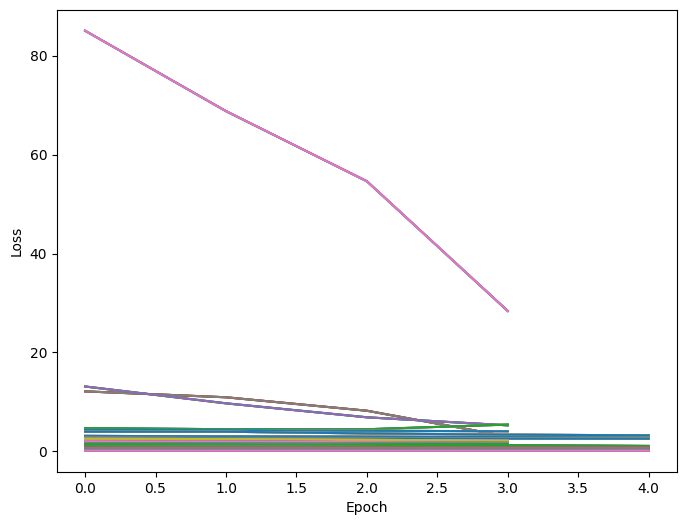

In [17]:
fig, ax = plt.subplots()

# Plot the training and validation loss values for each combination
for combo in loss_values:
    ax.plot(combo['train_loss'], label=f"Train Loss: {combo['hyperparameters']}")
    ax.plot(combo['val_loss'], label=f"Val Loss: {combo['hyperparameters']}")

# Add axis labels and a legend
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
# ax.legend()

# Show the plot
plt.show()

In [ ]:
batch_size = 5
num_epochs=10
lr=2e-5

In [47]:
quotes = new_dataset['quotes']
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', 
                                          bos_token='<|startoftext|>', 
                                          eos_token='<|endoftext|>', 
                                          pad_token='<|pad|>')

final_dataset = QuotesDataset(quotes, tokenizer,max_length_value)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [48]:
train_size = int(0.8*len(final_dataset))
val_size = len(final_dataset) - train_size
print(train_size,val_size)
train_dataset, val_dataset = random_split(final_dataset, [train_size, val_size])
train_dataloader = DataLoader(train_dataset,
                              sampler=RandomSampler(train_dataset),
                              batch_size=batch_size)

val_dataloader = DataLoader(val_dataset,
                            sampler=SequentialSampler(val_dataset),
                            batch_size=batch_size)

22959 5740


In [49]:
# Load model configuration
config = GPT2Config.from_pretrained("gpt2")

# Create model instance and set embedding length
model = GPT2LMHeadModel.from_pretrained("gpt2", config=config)
model.resize_token_embeddings(len(tokenizer))

# Running the model on GPU
model = model.to(device)

In [50]:
warmup_steps = 1e2
sample_every = 100

# Using AdamW optimizer with default parameters
optimizer = AdamW(model.parameters(), lr=lr, eps=1e-8)

# Toatl training steps is the number of data points times the number of epochs
total_training_steps = len(train_dataloader)*num_epochs

# Setting a variable learning rate using scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=warmup_steps,
                                            num_training_steps=total_training_steps)

c:\Users\priya\anaconda3\envs\my_env_2\lib\site-packages\transformers\optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [51]:
# wandb.init(
#     # set the wandb project where this run will be logged
#     project="quotes-generator-project-1",
    
#     # track hyperparameters and run metadata
#     config={
#     "learning_rate": lr,
#     "architecture": "GPT-2",
#     "dataset": "Quotes Dataset",
#     "epochs": num_epochs,
#     }
# )
# #Need to add batch size, optimization algorithm, dropout rate, gpt-2 models

In [ ]:
training_stats = []
all_training_loss=[]
all_valid_loss=[]
for epoch_i in range(num_epochs):
  print(f'Beginning epoch {epoch_i+1} of {num_epochs}')
  total_train_loss = 0
  model.train()

  # Labels are shifted by 1 timestep
  for step, batch in enumerate(train_dataloader):
    b_input_ids = batch[0].to(device)
    b_labels = batch[0].to(device)
    b_masks = batch[1].to(device)

    model.zero_grad()

    outputs = model(b_input_ids,
                    labels=b_labels,
                    attention_mask=b_masks)
    
    loss = outputs[0]

    batch_loss = loss.item()
    total_train_loss += batch_loss
    loss.backward()
    optimizer.step()
    scheduler.step()

  all_training_loss.append(total_train_loss)
  avg_train_loss = total_train_loss / len(train_dataloader)
  print(f'Average Training Loss: {avg_train_loss}.')
  model.eval()

  total_eval_loss = 0
  nb_eval_steps = 0

  for batch in val_dataloader:
    b_input_ids = batch[0].to(device)
    b_labels = batch[0].to(device)
    b_masks = batch[1].to(device)
        
    with torch.no_grad():        

        outputs  = model(b_input_ids,  
                         attention_mask = b_masks,
                         labels=b_labels)
          
        loss = outputs[0]  
            
    batch_loss = loss.item()
    total_eval_loss += batch_loss   

  all_valid_loss.append(total_eval_loss)
  avg_val_loss = total_eval_loss / len(val_dataloader)  
  print(f'Validation loss: {avg_val_loss}.')
  print()
  torch.save(model.state_dict(), f'gpt2_finetuned_epoch_{epoch_i}.pt')
  plt.plot(all_training_loss, label='Training Loss')
  plt.plot(all_valid_loss, label='Validation Loss')
  plt.ylim(bottom=0)
  plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  display.display(plt.gcf())
  display.clear_output(wait=True)
  # Record all statistics from this epoch.
  training_stats.append(
      {
          'epoch': epoch_i + 1,
          'Training Loss': avg_train_loss,
          'Valid. Loss': avg_val_loss,
      }
  )

In [ ]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel,GPT2Config

# Load the fine-tuned GPT-2 model and tokenizer
model_path = "gpt2_finetuned_epoch_9.pt"
my_tokenizer = GPT2Tokenizer.from_pretrained('gpt2', 
                                          bos_token='<|startoftext|>', 
                                          eos_token='<|endoftext|>', 
                                          pad_token='<|pad|>')
model_state_dict = torch.load(model_path, map_location=torch.device(device))


# Create a new model and load the state dict
config = GPT2Config.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained('gpt2',config=config)
model.resize_token_embeddings(len(my_tokenizer))

model.load_state_dict(model_state_dict)


prompt = "Empower"

generated = torch.tensor(my_tokenizer.encode(prompt)).unsqueeze(0)
sample_outputs = model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=50, 
                                max_length = 100,
                                top_p=0.95, 
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, my_tokenizer.decode(sample_output, skip_special_tokens=True)))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: Empowering yourself with these habits can provide you with unlimited opportunities to pursue your passion.”


1: Empower is as vital to happiness as health.”


2: Empower is a quality. a commitment to greatness. a constant effort to sharpen your skills.”


